In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F # stateless functions
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import sampler

import os
import pandas as pd
from skimage import io, transform
import numpy as np
import copy

import matplotlib.pyplot as plt

#import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.models as models

import time
from collections import defaultdict

import numpy as np 
import pandas as pd 
import slidingwindow as sw 
import skimage 
from skimage import io 
from pandas import DataFrame
import matplotlib.pyplot as plt
%matplotlib inline
import os 


from utils import *
from fastai2.vision.widgets import *

from fastai2.data.external import untar_data,URLs
from fastai2.data.transforms import get_image_files # 1
import torch 
from fastai2.data.core import DataLoaders
import random
from torchvision.models import resnet18
from fastai2.vision.all import *
from torch.utils.data  import Dataset
import re #2 
import random #3
from time import time #4
from fastai2.data.core import DataLoaders # 5
from fastai2.vision.all import * #6

In [ ]:
image_dir = '/project/yi_data/panda-16x128x128-tiles-data/train'
path = Path(image_dir)
fns = get_image_files(path)
BASE_FOLDER = "/project/data/"   # if on gcloud 
train = pd.read_csv(os.path.join(BASE_FOLDER, 'train.csv'))

In [23]:
def label_func2(filepath):
    """ input : FilePath
    """
    file_path = os.path.splitext(filepath)[0]
    image_id = file_path.split("/")[-1].split("_")[0]
    return train.loc[train['image_id']==image_id]['isup_grade'].values[0]

# label_func2('/project/yi_data/panda-16x128x128-tiles-data/train/06cab87cd7a132bd8eaa30aa1ea42434_8.png')


In [24]:
biopsy_images_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=label_func2,
    item_tfms=Resize(128))

In [26]:
dls = biopsy_images_db.dataloaders(path)

In [28]:
dls = dls.cuda()

In [33]:
class Model(nn.Module):
    def __init__(self, arch='resnext50_32x4d_ssl', n=6, pre=True):
        super().__init__()
        m = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models', arch)
        self.enc = nn.Sequential(*list(m.children())[:-2])       
        nc = list(m.children())[-1].in_features
        self.head = nn.Sequential(AdaptiveConcatPool2d(),Flatten(),nn.Linear(2*nc,512),
                            Mish(),nn.BatchNorm1d(512), nn.Dropout(0.5),nn.Linear(512,n))
        
    def forward(self, *x):
        shape = x[0].shape
        n = len(x)
        x = torch.stack(x,1).view(-1,shape[1],shape[2],shape[3])
        #x: bs*N x 3 x 128 x 128
        x = self.enc(x)
        #x: bs*N x C x 4 x 4
        shape = x.shape
        #concatenate the output for tiles into a single map
        x = x.view(-1,n,shape[1],shape[2],shape[3]).permute(0,2,1,3,4).contiguous()\
          .view(-1,shape[1],shape[2]*n,shape[3])
        #x: bs x C x N*4 x 4
        x = self.head(x)
        #x: bs x n
        return x

In [36]:
model = Model()
learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss(), 
                metrics=[accuracy]).to_fp16()

Using cache found in /home/abharani/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


In [39]:
# logger = CSVLogger(learn, f'log_RNXT50_1')
learn.clip_grad = 1.0
# learn.split([model.head])
learn.unfreeze()

In [44]:
learn.fit_one_cycle(16, max_lr=1e-3, div_factor=100, pct_start=0.0)

epoch,train_loss,valid_loss,accuracy,time
0,1.519124,1.628534,0.332739,27:48
1,1.480404,1.489228,0.396452,27:37
2,1.469393,1.444811,0.421473,27:35
3,1.464166,1.565449,0.321476,27:33
4,1.416414,1.439835,0.417967,27:32
5,1.423154,1.540526,0.381118,27:31
6,1.397157,4.675436,0.368191,27:31
7,1.365834,1.455260,0.401890,27:33
8,1.353944,2.697739,0.348786,27:35
9,1.332455,3.312987,0.355532,27:34


In [45]:
learn.export()
# path = Path()
# path.ls(file_exts='.pkl')
# learn_inf = load_learner(path/'lafoss.pkl')

In [48]:
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [47]:
path = Path()

In [58]:
preds,y,losses = learn.get_preds(with_loss=True)


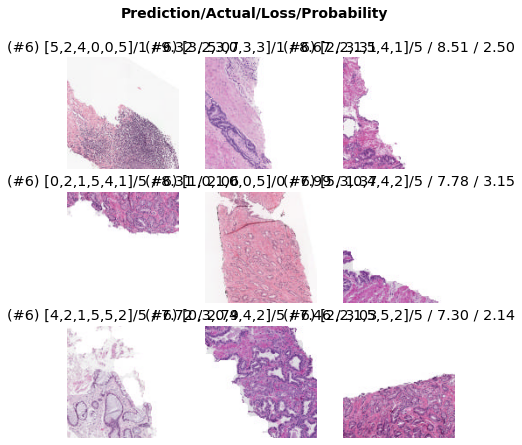

In [59]:
interp.plot_top_losses(9, figsize=(7,7))